In [1]:
# scientific libraries
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
from skimage import io

# general libraries
import os  
import json
import time
import h5py as h5py
import copy

# jupyter imports
import ipywidgets as widgets
from IPython.display import clear_output

# local libraries
from analysis import *
from general_utils import *
from hdf_utils import unpack_hdf, Workspace
from scalebars import *

import balance_configs as configs
import experiments as exps
import analysis as ana
from interactive import MotionResponse

In [2]:
%matplotlib widget
plt.rcParams.update({"figure.max_open_warning": 0})

In [3]:
base_path = "/mnt/Data/NEURONoutput/sac_net/"

In [4]:
model_path = os.path.join(base_path, "gaba_titration")
save_name = "test"
load_name = None
# load_name = "test"
# load_name = "control"
load_name = "control_6n_3tr_0p2_1p6"
# load_name = "no_nmda_6n_3tr_0p2_1p6"

model_config = configs.sac_mode_config(
    ttx=False,
    non_ds_ach=False,
    offset_ampa_ach=False,
    record_tree=False,
)
model_config["synprops"]["NMDA"]["pref_prob"] = 0.0
model_config["synprops"]["NMDA"]["null_prob"] = 0.0

if load_name is None:
    from ei_balance_nogui import *
    os.makedirs(model_path, exist_ok=True)
    save_path = os.path.join(model_path, save_name) + ".h5"
    load_name = save_name
    exps.sacnet_gaba_titration_run(
        save_path,
        model_config,
        n_nets=6,
        n_trials=3,
        rho_steps=[0.0, 1.0],
        # gaba_steps=[0.5, 1.],
        gaba_steps=[0.2, 0.4, 0.6, 0.8, 1., 1.2, 1.4, 1.6],
        pool_sz=6,
    )

hdf = h5.File(os.path.join(model_path, load_name) + ".h5", "r")
d = Workspace(hdf, read_only=True)
        
factors = list(d.keys())
rhos = list(d[factors[0]].keys())
idxs = list(d[factors[0]][rhos[0]].keys())

In [5]:
def close_button():
    button = widgets.Button(description="Close Workspace")
    out = widgets.Output()

    def on_clicked(_):
        with out:
            clear_output()
            d.close()
            print("File closed!")
        
    button.on_click(on_clicked)
    return widgets.VBox([button, out])

close_button()

In [6]:
metrics = {k: ana.get_sac_metrics(d[k]) for k in factors}

dir_labels = d[factors[0]][rhos[0]][idxs[0]]["params"]["dir_labels"][:]
sac_thetas = ana.get_sac_thetas(d[factors[0]])
sac_deltas = ana.get_sac_deltas(sac_thetas)

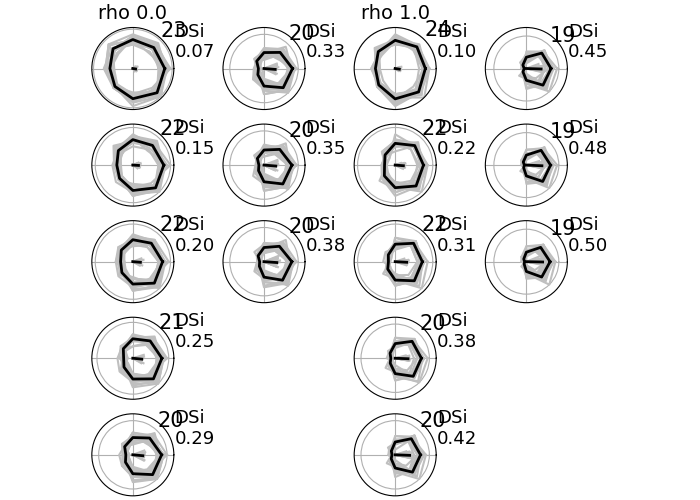

In [7]:
max_spikes = np.max([r["spikes"] for s in factors for r in metrics[s].values()])
polar_fig = plt.figure(figsize=(7, 5))
max_rows = 5
n_rows = min(max_rows, len(factors))
splits = int(np.ceil(len(factors) / max_rows))
n_cols = len(rhos) * splits
polar_ax = []
for i, factor in enumerate(factors):
    row = i % max_rows
    subcol = i // max_rows
    for j, (rho, m) in enumerate(metrics[factor].items()):
        polar_ax.append(polar_plot(
            m,
            dir_labels,
            title=None,
            title_metrics=False,
            radius=max_spikes,
            net_shadows=False,
            save=False,
            fig=polar_fig,
            sub_loc=(n_rows, n_cols, (row * n_cols + j * splits + subcol + 1)),
        ))

for i in range(len(rhos)):
    polar_ax[i].set_title("rho %.1f" % rhos[i], fontsize=14)
    
polar_fig.set_layout_engine("compressed")

In [8]:
avg_spikes = {
    fac: {rho: np.mean(nets["spikes"], axis=(0, 1)) for rho, nets in exps.items()}
    for fac, exps in metrics.items()
}
dirs_180 = np.array([ana.scale_180_from_360(d) for d in  dir_labels])
dir_sort = np.argsort(dirs_180)
dirs_sorted = dir_labels[dir_sort]
dirs_180_sorted = dirs_180[dir_sort]

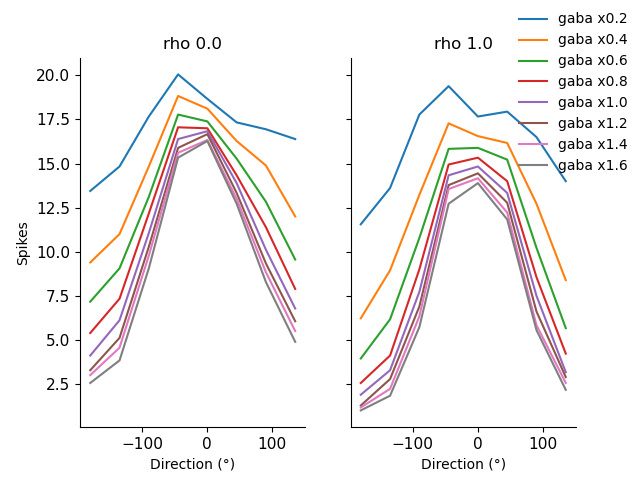

In [9]:
tuning_fig, tuning_ax = plt.subplots(1, len(rhos), sharey=True)
for i, (ax, rho) in enumerate(zip(tuning_ax, rhos)):
    ax.set_xlabel("Direction (°)")
    ax.set_title("rho " + str(rho))
    for factor in factors:
        lbl = ("gaba x" + str(factor)) if not i else None
        ax.plot(dirs_180_sorted, avg_spikes[factor][rho][dir_sort], label=lbl)
tuning_ax[0].set_ylabel("Spikes")
tuning_fig.legend(frameon=False)
clean_axes(tuning_ax)

In [10]:
close_button()